# Modelling the Fano 2024, Italy dengue outbreaks: The effects of control strategies and environmental extremes
**Author:** Sandeep Tegar<sup>1, 2</sup> and Dominic P. Brass<sup>1</sup> 

**Contact:** santeg@ceh.ac.uk  
**Date:** 2025-03-17   
**Affiliation:**
1. UK Centre for Ecology & Hydrology, Benson Lane, Wallingford, Oxfordshire, UK
2. School of Mathematics and Statistics, College of Science and Engineering, University of Glasgow, Glasgow, UK   


## Overview  
This notebook contains the code used in our study. It performs model simulation using function `dengue()`and error analysis using function `seeding_error()`. Finally, it plots the output.  

## Requirements  
- Julia 1.10.0+  
- Required libraries: `Plots`, `DelayDiffEq`, `Dierckx`, `CSV`, `Interpolations`, `QuadGK`, `Statistics`, `Dates`, `DataFrames`, `RecurssiveArrayTools`, `TimeSeries` 
- Data files: `AMgam.csv`, `Car_Tol_1.csv`, `Fin_LSurv.csv`, `LDgam.csv`, `WL_re.csv`
- Function files: DengueFun.jl and ErrorFun.jl
## Extra requirement
1. ERA5 climate data file "43.82_13.026.csv" (format: latitude_longitude.csv) coulmns: time, logitude, latitude, t2m, tp, evaow, where 't2m', 'tp', and 'evaow' stand for  "2m_temperature", "total_precipitation", and "evaporation_from_open_water_surfaces_excluding_oceans", respectively. Source: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview
2. Reported dengue cases "fano_data.csv". Source: https://doi.org/10.2807/1560-7917.ES.2024.29.47.2400713  

## Usage  
Save all the required files in the working directory and simply run the cells in order to reproduce the results.  

In [1]:
# Required packages
using Plots, DelayDiffEq, Dierckx, CSV, Interpolations, QuadGK, Statistics, Dates, DataFrames, RecursiveArrayTools, TimeSeries

In [2]:
# call the functions dengue() and seeding_error() from the files DengueFun.jl and ErrorFun.jl
include("DengueFun.jl")
include("ErrorFun.jl")

seeding_error (generic function with 1 method)

In [3]:
# compute errros
# compared range from "2024-06-30" to "2024-08-10"
# change for demo from "2024-06-30" to "2024-07-01"
seeding_start = Date("2024-06-30", "yyyy-mm-dd")
seeding_end = Date("2024-07-01", "yyyy-mm-dd")
error = seeding_error(seeding_start, seeding_end)

2×4 TimeArray{Float64, 2, Date, Matrix{Float64}} 2024-06-30 to 2024-07-01
┌────────────┬──────────┬─────────┬───────────┬───────────┐
│            │ R2       │ RMSE    │ NSE       │ KGE12     │
├────────────┼──────────┼─────────┼───────────┼───────────┤
│ 2024-06-30 │ 0.648217 │ 5.03217 │ -0.979926 │ -0.203637 │
│ 2024-07-01 │ 0.648766 │ 3.39367 │ 0.0995136 │  0.210755 │
└────────────┴──────────┴─────────┴───────────┴───────────┘

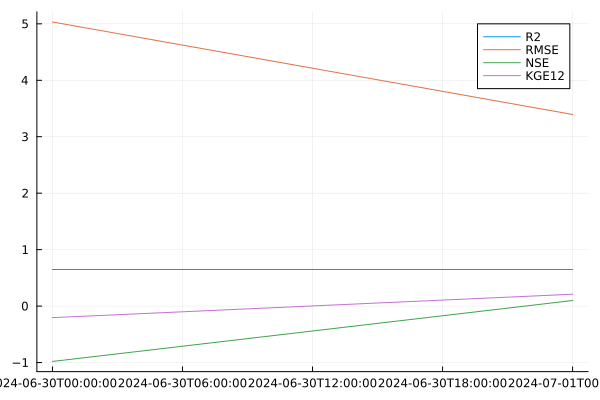

In [ ]:
# plotting errors
plot(error)

In [ ]:
# save error to csv file (remove # from the code to save it)
#CSV.write("fano_simulation/error.csv", error)

"fano_simulation/error.csv"

In [6]:
# Find the best dates by daily cases
#R2_opt    = findwhen(error["R2"] .== values(maximum(error["R2"])))
RMSE_opt  = findwhen(error["RMSE"] .== values(minimum(error["RMSE"])))
NSE_opt   = findwhen(error["NSE"] .== values(maximum(error["NSE"])))
KGE_opt   = findwhen(error["KGE12"] .== values(maximum(error["KGE12"])))
(RMSE_opt, NSE_opt, KGE_opt)

([Date("2024-07-01")], [Date("2024-07-01")], [Date("2024-07-01")])

In [8]:
# Read Fano data
# Required file "fano_data.csv"
fano_df = CSV.read("fano_data.csv", DataFrame)
fano_df.date = DateTime.(fano_df.date, "dd/mm/yyyy")
fano_data = (datetime    = Date.(fano_df.date),
             daily_cases = fano_df.daily_cases,
             cum_cases   = fano_df.cum_cases)
fano_ts = TimeArray(fano_data; timestamp = :datetime);

In [9]:
# Simulate model for seeding date with the lower bound
start_date_str = "18.11.2021"
seed_date_str = string(Dates.format(Date(2024, 07, 03), "dd.mm.yyyy"))
solE1 = dengue(43.82, 13.026, start_date_str, "18.11.2024", seed_date_str);

# Simulate model for seeding date with the optimum error
start_date_str = "18.11.2021"
seed_date_str = string(Dates.format(Date(2024, 07, 17), "dd.mm.yyyy"))
solopt = dengue(43.82, 13.026, start_date_str, "18.11.2024", seed_date_str);

# Simulate model for seeding date with the upper bound
start_date_str = "18.11.2021"
seed_date_str = string(Dates.format(Date(2024, 07, 31), "dd.mm.yyyy"))
solE2 = dengue(43.82, 13.026, start_date_str, "18.11.2024", seed_date_str);

In [10]:
# computing daily new cases 
dsolE1 = diff(solE1);
dsolopt = diff(solopt);
dsolE2 = diff(solE2);

recrE1 = dsolE1["i_inst"] .+ dsolE1["Hr"];
recropt = dsolopt["i_inst"] .+ dsolopt["Hr"];
recrE2 = dsolE2["i_inst"] .+ dsolE2["Hr"];

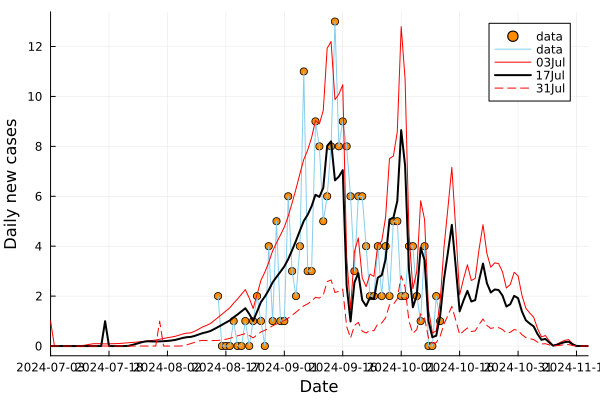

In [11]:
# plotting the simulation output and reported cases
# Define the xticks range
xtiks = Date(2024, 7, 03):Day(15):Date(2024, 11, 18)

# Format the xticks as strings
xtik_labels = Dates.format.(xtiks, "yyyy-mm-dd")

# Plot with xticks explicitly set
scatter(fano_ts["daily_cases"],
    xlims=(Date("2024-07-03"), Date("2024-11-18")),
    xticks=(xtiks, xtik_labels),  # Provide both positions and labels
    label="data", xlabel="Date", ylabel="Daily new cases",
    color=:darkorange, markersize=4)
plot!(fano_ts["daily_cases"], 
    xlims=(Date("2024-07-03"), Date("2024-11-18")),
    xticks=(xtiks, xtik_labels),  # Provide both positions and labels
    label="data", xlabel="Date", ylabel="Daily new cases",
    lc=:skyblue, lw=1)
plot!(recrE1,
      xlims=(Date("2024-07-03"), Date("2024-11-18")),
      xticks=(xtiks, xtik_labels),
      label="03Jul", xlabel="Date", ylabel="Daily new cases",
      lc=:red, lw=1)
plot!(recropt,
      xlims=(Date("2024-07-03"), Date("2024-11-18")),
      xticks=(xtiks, xtik_labels),
      label="17Jul", xlabel="Date", ylabel="Daily new cases",
      lc=:black, lw=2)
plot!(recrE2,
      xlims=(Date("2024-07-03"), Date("2024-11-18")),
      xticks=(xtiks, xtik_labels),
      label="31Jul", xlabel="Date", ylabel="Daily new cases",
      lc=:red, lw=1, linestyle = :dash)

In [ ]:
# uncomment to save fig if needed
#savefig("fano_daily_cases_c.pdf")

In [ ]:
# uncomment to save the Fano data
#fano_df = DataFrame(fano_df)
#CSV.write("fano_simulation/fano_sim_C/fano_cases.csv", fano_df)

"fano_simulation/fano_sim_C/fano_cases.csv"

In [ ]:
# uncomment to save the smulation ouput
#sol_low_df = DataFrame(solE1);
#sol_opt_df = DataFrame(solopt);
#sol_up_df = DataFrame(solE2);

#CSV.write("fano_simulation/fano_sim_C/fano_sim_low.csv", sol_low_df)
#CSV.write("fano_simulation/fano_sim_C/fano_sim_opt.csv", sol_opt_df)
#CSV.write("fano_simulation/fano_sim_C/fano_sim_up.csv", sol_up_df)

In [ ]:
# uncomment to save the derivative of smulation output
#dsol_low_df = DataFrame(dsolE1);
#dsol_opt_df = DataFrame(dsolopt);
#dsol_up_df = DataFrame(dsolE2);

#CSV.write("fano_simulation/fano_sim_C/diff_fano_sim_low.csv", dsol_low_df)
#CSV.write("fano_simulation/fano_sim_C/diff_fano_sim_opt.csv", dsol_opt_df)
#CSV.write("fano_simulation/fano_sim_C/diff_fano_sim_up.csv", dsol_up_df)
